# Deep Gaussian Processes
## Introduction

In this notebook, we provide a GPyTorch implementation of deep Gaussian processes, where training and inference is performed using the method of Salimbeni et al., 2017 (https://arxiv.org/abs/1705.08933) adapted to CG-based inference.

We'll be training a simple two layer deep GP on the `elevators` UCI dataset.

In [274]:
%set_env CUDA_VISIBLE_DEVICES=0

import torch
import tqdm
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood


env: CUDA_VISIBLE_DEVICES=0


In [275]:
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

### Loading Data

For this example notebook, we'll be using the `elevators` UCI dataset used in the paper. Running the next cell downloads a copy of the dataset that has already been scaled and normalized appropriately. For this notebook, we'll simply be splitting the data using the first 80% of the data as training and the last 20% as testing.

**Note**: Running the next cell will attempt to download a ~400 KB dataset file to the current directory.

In [276]:
import urllib.request
import os
from math import floor

import torch
import pickle
import torch

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

# Load dataset
def load_dataset(path, prefilter=True):
    data_dict = pickle.load(open(path, "rb"))
    df = data_dict["df"]
    if prefilter:
        X = data_dict["X"][df["big_OD"]]
        y = df["norm_TSNAK"][df["big_OD"]].values
        groups = df["variant"][df["big_OD"]].values
        od = df["OD"][df["big_OD"]].values
    else:
        X = data_dict["X"]
        y = df["norm_TSNAK"].values
        groups = df["variant"].values
        od = df["OD"].values
        
    return X, y, groups, od

# this is for running the notebook in our testing framework
smoke_test = False

# path=r'.\data\ArM\data_set_dict.pkl'
# X, y, groups, od = load_dataset(path, prefilter=True)

# splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 0)
# train_idx, val_idx = next(splitter.split(X, y, groups))

# # Use the indices to split the data
# X_train, X_val = X[train_idx], X[val_idx]
# y_train, y_val = y[train_idx], y[val_idx]
# od_train, od_val = od[train_idx], od[val_idx]

# #from validation set drop certain outliers which have OD < 0.018
# X_val = X_val[od_val > 0.018]
# y_val = y_val[od_val > 0.018]
# od_val = od_val[od_val > 0.018]

# Split data into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# load sklearn regression dataset
from sklearn.datasets import load_diabetes

data = load_diabetes()
X = data['data']
y = data['target']

print(X.shape, y.shape)

#sinc function
# import numpy as np

# def sinc(x):
#     return np.sinc(x)

# X = np.linspace(-2, 2, 50).reshape(-1, 1)
# y = sinc(X).ravel()


# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Standardize y
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).ravel()


if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = torch.tensor(X_train).cuda(), torch.tensor(y_train).cuda(), torch.tensor(X_val).cuda(), torch.tensor(y_val).cuda()
else:
    train_x, train_y, test_x, test_y = torch.tensor(X_train), torch.tensor(y_train), torch.tensor(X_val), torch.tensor(y_val)
    
#float32
train_x = train_x.float()
train_y = train_y.float()
test_x = test_x.float()
test_y = test_y.float()

(442, 10) (442,)


In [277]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

## Defining GP layers

In GPyTorch, defining a GP involves extending one of our abstract GP models and defining a `forward` method that returns the prior. For deep GPs, things are similar, but there are two abstract GP models that must be overwritten: one for hidden layers and one for the deep GP model itself.

In the next cell, we define an example deep GP hidden layer. This looks very similar to every other variational GP you might define. However, there are a few key differences:

1. Instead of extending `ApproximateGP`, we extend `DeepGPLayer`.
2. `DeepGPLayers` need a number of input dimensions, a number of output dimensions, and a number of samples. This is kind of like a linear layer in a standard neural network -- `input_dims` defines how many inputs this hidden layer will expect, and `output_dims` defines how many hidden GPs to create outputs for.

In this particular example, we make a particularly fancy `DeepGPLayer` that has "skip connections" with previous layers, similar to a ResNet.

In [278]:
class ToyDeepGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=128, mean_type='constant'):
        if output_dims is None:
            inducing_points = torch.randn(num_inducing, input_dims)
            batch_shape = torch.Size([])
        else:
            inducing_points = torch.randn(output_dims, num_inducing, input_dims)
            batch_shape = torch.Size([output_dims])

        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )

        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        super(ToyDeepGPHiddenLayer, self).__init__(variational_strategy, input_dims, output_dims)

        if mean_type == 'constant':
            self.mean_module = ConstantMean(batch_shape=batch_shape)
        else:
            self.mean_module = LinearMean(input_dims)
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=batch_shape, ard_num_dims=input_dims),
            batch_shape=batch_shape, ard_num_dims=None
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    def __call__(self, x, *other_inputs, **kwargs):
        """
        Overriding __call__ isn't strictly necessary, but it lets us add concatenation based skip connections
        easily. For example, hidden_layer2(hidden_layer1_outputs, inputs) will pass the concatenation of the first
        hidden layer's outputs and the input data to hidden_layer2.
        """
        if len(other_inputs):
            if isinstance(x, gpytorch.distributions.MultitaskMultivariateNormal):
                x = x.rsample()

            processed_inputs = [
                inp.unsqueeze(0).expand(gpytorch.settings.num_likelihood_samples.value(), *inp.shape)
                for inp in other_inputs
            ]

            x = torch.cat([x] + processed_inputs, dim=-1)

        return super().__call__(x, are_samples=bool(len(other_inputs)))

## Building the deep GP

Now that we've defined a class for our hidden layers and a class for our output layer, we can build our deep GP. To do this, we create a `Module` whose forward is simply responsible for forwarding through the various layers.

This also allows for various network connectivities easily. For example calling,
```
hidden_rep2 = self.second_hidden_layer(hidden_rep1, inputs)
```
in forward would cause the second hidden layer to use both the output of the first hidden layer and the input data as inputs, concatenating the two together.

In [279]:
num_hidden_dims = 2 if smoke_test else 10


class DeepGP(DeepGP):
    def __init__(self, train_x_shape):
        hidden_layer = ToyDeepGPHiddenLayer(
            input_dims=train_x_shape[-1],
            output_dims=num_hidden_dims,
            mean_type='linear',
        )
        
        last_layer = ToyDeepGPHiddenLayer(
            input_dims=hidden_layer.output_dims,
            output_dims=None,
            mean_type='constant',
        )
        
        super().__init__()
        
        self.hidden_layer = hidden_layer
        self.last_layer = last_layer
        self.likelihood = GaussianLikelihood()
    
    def forward(self, inputs):
        hidden_rep1 = self.hidden_layer(inputs)
        output = self.last_layer(hidden_rep1)
        return output
    
    def predict(self, test_loader):
        with torch.no_grad():
            mus = []
            variances = []
            lls = []
            for x_batch, y_batch in test_loader:
                preds = self.likelihood(self(x_batch))
                mus.append(preds.mean)
                variances.append(preds.variance)
                lls.append(model.likelihood.log_marginal(y_batch, model(x_batch)))
        
        return torch.cat(mus, dim=-1), torch.cat(variances, dim=-1), torch.cat(lls, dim=-1)

In [280]:
import matplotlib.pyplot as plt

def parity_plot(y_true, y_pred):
    plt.scatter(y_true, y_pred)
    plt.xlabel("True")
    plt.ylabel("Predicted")
    #square aspect ratio
    plt.gca().set_aspect('equal', adjustable='box')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=1)
    plt.show()

## Objective function (approximate marginal log likelihood/ELBO)

Because deep GPs use some amounts of internal sampling (even in the stochastic variational setting), we need to handle the objective function (e.g. the ELBO) in a slightly different way. To do this, wrap the standard objective function (e.g. `~gpytorch.mlls.VariationalELBO`) with a `gpytorch.mlls.DeepApproximateMLL`.

## Training/Testing

The training loop for a deep GP looks similar to a standard GP model with stochastic variational inference.

In [281]:

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model_gp = ExactGPModel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
model_gp.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model_gp.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_gp)

training_iter = 500
epochs_iter = tqdm.notebook.tqdm(range(training_iter), desc="Training", leave=False)
for i in epochs_iter:
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Calc loss and backprop gradients
    output = model_gp(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    epochs_iter.set_postfix(loss=loss.item())
    
    


Training:   0%|          | 0/500 [00:00<?, ?it/s]

In [282]:
# Inspect the state dictionary keys
print("model_gp.covar_module state_dict keys:", model_gp.covar_module.state_dict().keys())


model_gp.covar_module state_dict keys: odict_keys(['raw_outputscale', 'base_kernel.raw_lengthscale', 'base_kernel.raw_lengthscale_constraint.lower_bound', 'base_kernel.raw_lengthscale_constraint.upper_bound', 'raw_outputscale_constraint.lower_bound', 'raw_outputscale_constraint.upper_bound'])


In [283]:

# Initialize your DeepGP model
model = DeepGP(train_x.shape)
if torch.cuda.is_available():
    model = model.cuda()

# Get the state dictionaries
gp_state_dict = model_gp.covar_module.state_dict()
hidden_layer_state_dict = model.hidden_layer.state_dict()

# Debug: Check available keys
print("GP covar_module keys:", gp_state_dict.keys())
print("Hidden layer keys:", hidden_layer_state_dict.keys())

# Extract the lengthscales
if "base_kernel.raw_lengthscale" in gp_state_dict:
    lengthscale = gp_state_dict["base_kernel.raw_lengthscale"]
    print("Original lengthscale shape (model_gp):", lengthscale.shape)

    # Check for the corresponding key in the hidden layer
    target_key = "covar_module.base_kernel.raw_lengthscale"
    if target_key in hidden_layer_state_dict:
        # Debug: Expected shape in hidden layer
        print("Expected lengthscale shape (hidden layer):", hidden_layer_state_dict[target_key].shape)

        # Reshape if necessary
        if hidden_layer_state_dict[target_key].shape != lengthscale.shape:
            lengthscale = lengthscale.expand(hidden_layer_state_dict[target_key].shape)
            print("Reshaped lengthscale to:", lengthscale.shape)

        # Assign the reshaped lengthscale
        hidden_layer_state_dict[target_key] = lengthscale
    else:
        raise KeyError(f"Key '{target_key}' not found in hidden_layer_state_dict!")
else:
    raise KeyError("Lengthscale key ('base_kernel.raw_lengthscale') not found in gp_state_dict!")

# Load the updated state dictionary into the hidden layer
model.hidden_layer.load_state_dict(hidden_layer_state_dict, strict=False)
print("Lengthscale parameters successfully transferred!")


GP covar_module keys: odict_keys(['raw_outputscale', 'base_kernel.raw_lengthscale', 'base_kernel.raw_lengthscale_constraint.lower_bound', 'base_kernel.raw_lengthscale_constraint.upper_bound', 'raw_outputscale_constraint.lower_bound', 'raw_outputscale_constraint.upper_bound'])
Hidden layer keys: odict_keys(['variational_strategy.inducing_points', 'variational_strategy.variational_params_initialized', 'variational_strategy.updated_strategy', 'variational_strategy._variational_distribution.variational_mean', 'variational_strategy._variational_distribution.chol_variational_covar', 'mean_module.weights', 'mean_module.bias', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'covar_module.base_kernel.raw_lengthscale_constraint.lower_bound', 'covar_module.base_kernel.raw_lengthscale_constraint.upper_bound', 'covar_module.raw_outputscale_constraint.lower_bound', 'covar_module.raw_outputscale_constraint.upper_bound'])
Original lengthscale shape (model_gp): torch.Size([1

In [284]:
# this is for running the notebook in our testing framework
num_epochs = 1 if smoke_test else 100
num_samples = 3 if smoke_test else 100


optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.05)
mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, train_x.shape[-2]))

epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        with gpytorch.settings.num_likelihood_samples(num_samples):
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            optimizer.step()

            minibatch_iter.set_postfix(loss=loss.item())
    
    epochs_iter.set_postfix(loss=loss.item())
    

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

The output distribution of a deep GP in this framework is actually a mixture of `num_samples` Gaussians for each output. We get predictions the same way with all GPyTorch models, but we do currently need to do some reshaping to get the means and variances in a reasonable form.

Note that you may have to do more epochs of training than this example to get optimal performance; however, the performance on this particular dataset is pretty good after 10.

RMSE: 0.6719130873680115, NLL: 1.0192687511444092
0.4822167754173279


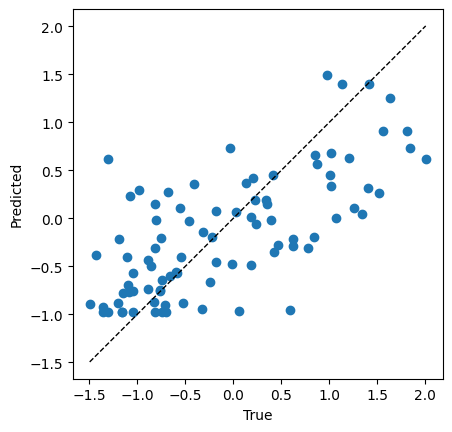

In [285]:
import gpytorch
import math

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=1024)

model.eval()
predictive_means, predictive_variances, test_lls = model.predict(test_loader)

rmse = torch.mean(torch.pow(predictive_means.mean(0) - test_y, 2)).sqrt()
print(f"RMSE: {rmse.item()}, NLL: {-test_lls.mean().item()}")

from sklearn.metrics import r2_score

print(r2_score(test_y.cpu().numpy(), predictive_means.mean(0).cpu().numpy()))

parity_plot(test_y.cpu().numpy(), predictive_means.mean(0).cpu().numpy())

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

RMSE: 0.6531310677528381
0.5107593536376953


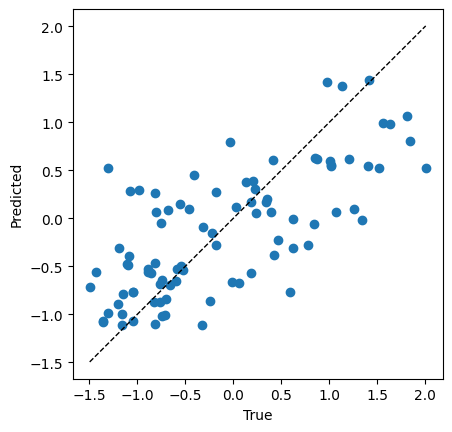

In [286]:
#gpytorch benchmark
import gpytorch


# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 500
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Calc loss and backprop gradients
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    epochs_iter.set_postfix(loss=loss.item())
    
    

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)
# y_pred = rf.predict(X_val)
# rmse =  root_mean_squared_error(y_val, y_pred)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    y_pred = model(test_x).mean
rmse = torch.mean(torch.pow(y_pred - test_y, 2)).sqrt()
print(f"RMSE: {rmse.item()}")
print(r2_score(test_y.cpu().numpy(), y_pred.cpu().numpy()))

parity_plot(test_y.cpu().numpy(), y_pred.cpu().numpy())

RMSE: 0.6968847193228533
0.4430147382946368


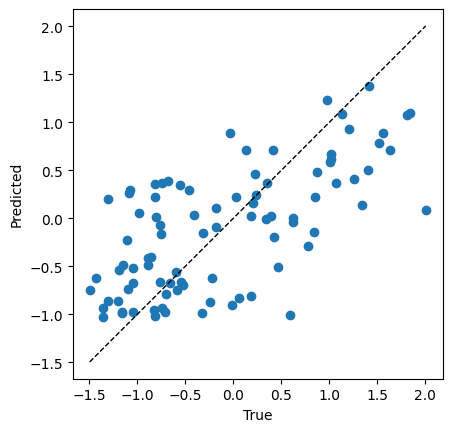

In [287]:
#sklearn RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
rmse =  root_mean_squared_error(y_val, y_pred)
print(f"RMSE: {rmse}")

print(r2_score(y_val, y_pred))


parity_plot(y_val, y_pred)

ValueError: x and y must be the same size

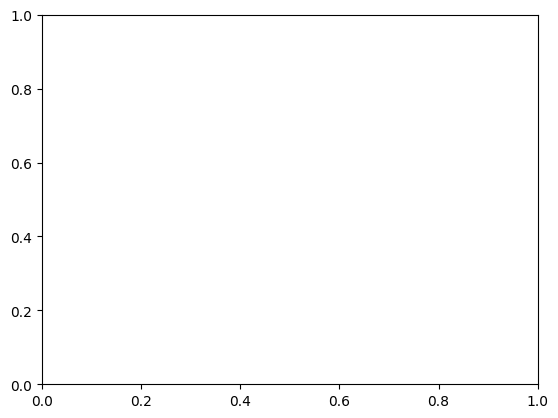

In [288]:
# visualize predictions

# x over y

plt.scatter(X, y, color='black', lw=0.5)